<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/project_ATPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting from section 4.1 of the book **Deep Learning with Python**: single-label binary classification model

## Dataset

In [12]:
from tensorflow.keras.datasets import imdb    # imdb is a dataset with reviews (encoded in numbers)

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)                                                    # keeps the TOP10000 words only.

# In this case 10000 most frequent individual words in the dataset,
# This is: we keep all review, but inside each we only keep "top words"


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Both train_data and test_data are **lists with nested lists inside**, each of the nested lists is a review, where each word is casted into a number.
(each word in the dictionary is equivalente to a specific number)

In [13]:
train_data[:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

Both train_labels and test_labels are lists of 0/1 label, where 0=negative review and 1=positive review.

In [14]:
train_labels[8]

np.int64(1)

### Extra: decoding back to natural laguage


In [15]:
word_index = imdb.get_word_index()    # dict that maps each word to its code number

reverse_word_index = dict(            # dict inverting value and key (number to word)
    [(value, key) for (key, value) in word_index.items()])

# Decoding train_data[0]
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Turning the list of words(numbers) into tensors

The underlying idea is that we want to have a matrix with 10000 columns (one for each of the top10000 words) and a row for each review.

(The book uses 'sequence' instead of 'review')

In [16]:
import numpy as np

def vectorize_reviews(reviews, dimension=10000):     # dimension=10000 because there are 10000 different words
  results = np.zeros((len(reviews), dimension))      # starting with a tensor of all 0.(s)
  for i, review in enumerate(reviews):
    for j in review:                                # j is each index inside a nested list in data = each word in a review
      results[i, j] = 1.                            # inside a tensor inside "results", 1. is that word appers
  return results

x_train = vectorize_reviews(train_data)
x_test = vectorize_reviews(test_data)

x_train[0]

# After the transformation above, each review is now a RANK-1 TENSOR with 10000 dimensions.

array([0., 1., 1., ..., 0., 0., 0.])

Similarly, we need to vectorize labels. For that, we do the following:

In [17]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## The model

Choosing the architecture of the model:

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),      # first layer: 16 perceptrons, using relu
    layers.Dense(16, activation="relu"),      # second layer: (same)
    layers.Dense(1, activation="sigmoid")     # output layer: 1 perceptron, using sigmoid (binary outcome)
])

In [19]:
model.compile(optimizer="rmsprop",            # choosing optimizer
              loss="binary_crossentropy",     # choosing loss function
              metrics=["accuracy"])           # choosing accuracy metrics

Extracting part of the trainnig data to be assigned to validation.

In [20]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Let's now train the model.

In [21]:
# Remember .fit() returns a dictionary of all that happen during training (see next cell)
history = model.fit(partial_x_train,
                          partial_y_train,
                          epochs=20,
                          batch_size=512,
                          validation_data=(x_val, y_val))
# history is an 'History' object

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.6977 - loss: 0.6039 - val_accuracy: 0.8639 - val_loss: 0.4065
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8938 - loss: 0.3438 - val_accuracy: 0.8764 - val_loss: 0.3283
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9175 - loss: 0.2600 - val_accuracy: 0.8882 - val_loss: 0.2865
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9368 - loss: 0.2036 - val_accuracy: 0.8779 - val_loss: 0.3017
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1686 - val_accuracy: 0.8880 - val_loss: 0.2793
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9541 - loss: 0.1473 - val_accuracy: 0.8767 - val_loss: 0.3071
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9655 - loss: 0.1254 - val_accuracy: 0.8844 - val_loss: 0.2893
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9693 - loss: 0.1114 - val_accuracy: 0.8810 - 

### Taking a look at model_history

In [22]:
# History objects have a member 'history' that is a dict
history_dict = history.history

history_dict.keys()
# history_dict.values()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## Plotting:

Loss

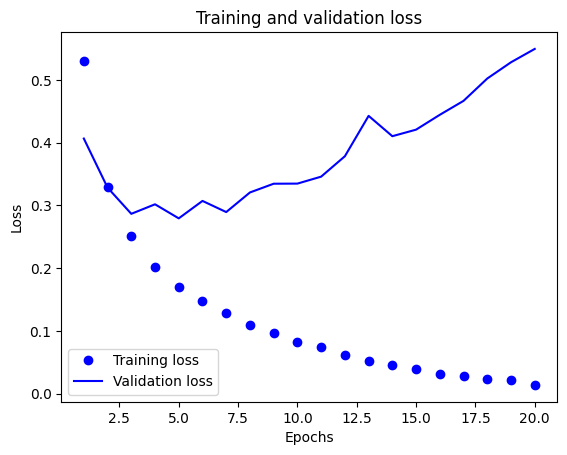

In [23]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy

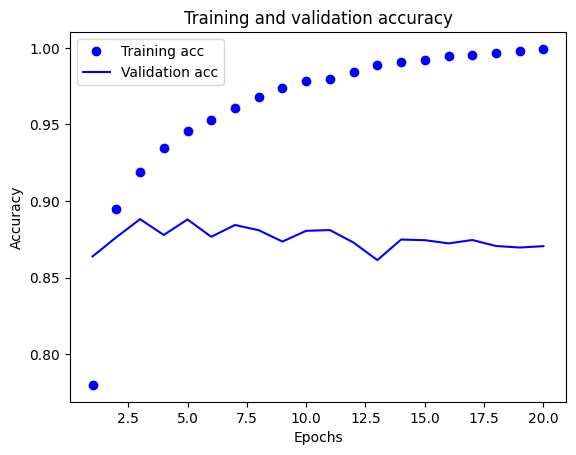

In [24]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Retraining the model in all the train data and evaluation in test data.
After that we are computing the results.

In [25]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(x_test, y_test)

results

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7295 - loss: 0.5625
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9008 - loss: 0.2913
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9282 - loss: 0.2113
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9392 - loss: 0.1758
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8840 - loss: 0.2894


[0.28795307874679565, 0.8850399851799011]

## Making predictions

In [26]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.18747982],
       [0.9993566 ],
       [0.77791613],
       ...,
       [0.09947266],
       [0.07847819],
       [0.4959459 ]], dtype=float32)

## Can we improve the model? How?

We experiment different architecture:
1. Add another layer / Take out one layer.
2. Increse/Decrease perceptrons inside layers (usualy factors of 8: 32, 64, 128).
3. Try 'mse' for loss function.
4. Try 'tanh' for activation function.

# Section 4.2 of the book **Deep Learning with Python**: Single-label multiclass clasification model

## Dataset

In [32]:
from tensorflow.keras.datasets import reuters   # Dataset with news labeled with a topic

(train_data, train_labels),(test_data, test_label) = reuters.load_data(num_words = 100000)
# again we are only interested in the TOP10000 words

In [33]:
len(train_data)

8982

In [34]:
len(test_data)

2246

Note that the format of the data is the same as in the previous case, where each piece of news is encode into a list of integers, being each of them correspondent to a word.

### extra: decoding back to word

(Same as in imdb case)

In [35]:
word_index = reuters.get_word_index()    # dict that maps each word to its code number

reverse_word_index = dict(            # dict inverting value and key (number to word)
    [(value, key) for (key, value) in word_index.items()])

# Decoding train_data[0]
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_newswire

'? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## Turning lists into tensors (same code as before)

In [42]:
# Dont understand this error
x_train = vectorize_news(train_data)   # we might want to change the name of this function
x_test = vectorize_news(test_data)

IndexError: index 27595 is out of bounds for axis 1 with size 10000

In [37]:
# Vectorizing labels (diferent than in the previous case because there are more than 2 labels)

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

# this yields a matrix with 46 dimensions(columns),
# where all values in a row are 0 except in the column with the number of the correct label

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [38]:
# There is all this built in way to do it
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(train_labels)
# y_test = to_categorical(test_labels)

## The model

Choosing the architecture, we have to keep in mind that we now want to learn from 46 different label. Therefore, it is reasonable to say we need more than 16 perceptrons per layer, at least we would use 46. (Let's try with 64)

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
    ])

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",    # CHECK THE BOOK TO SEE WHY THIS ARE GOOD FITS
              metrics=["accuracy"])

Let's compute validation datasets.

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

Lest's now train the model

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

## Plotting

In [ ]:
# Loss
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()